In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip setuptools wheel
# !{sys.executable} -m pip install networkx numpy matplotlib pandas pydot

In [2]:
import networkx as nx
import itertools as it
import matplotlib.pyplot as plt
import math
import scipy
import pickle
import os

In [3]:
DPI = 300

In [4]:
BaseDirectory = os.getcwd()

In [5]:
# print(BaseDirectory)

In [6]:
def _draw_graph_list(GraphList):
    if len(GraphList) <= 0:
        return
    elif len(GraphList) == 1:
        Dimension = 1
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(Dimension*Dimension,Dimension*Dimension),dpi=200)
        nx.draw_circular(GraphList[0], ax=axes, label=f"Graph {1}", with_labels=True, edge_color='black', node_color='black', font_color='white')
    else:
        Dimension = math.ceil(math.sqrt(len(GraphList)))
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(Dimension*Dimension,Dimension*Dimension),dpi=200)
        GraphCounter=0
        for x in range(0,Dimension):
            for y in range(0,Dimension):
                if GraphCounter < len(GraphList):
                    nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], label=f"Graph {GraphCounter}", with_labels=True, edge_color='black', node_color='black', font_color='white')
                    GraphCounter+=1
                else:
                    nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.show()
    plt.close()
    return

In [7]:
def _save_graph_list(GraphList, FileName = "Default"):
    if len(GraphList) <= 0:
        return
    elif len(GraphList) == 1:
        Dimension = 1
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(Dimension*Dimension,Dimension*Dimension),dpi=200)
        nx.draw_circular(GraphList[0], ax=axes, label=f"Graph {1}", with_labels=True, edge_color='black', node_color='black', font_color='white')
    else:
        Dimension = math.ceil(math.sqrt(len(GraphList)))
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(Dimension*Dimension,Dimension*Dimension),dpi=200)
        GraphCounter=0
        for x in range(0,Dimension):
            for y in range(0,Dimension):
                if GraphCounter < len(GraphList):
                    nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], label=f"Graph {GraphCounter}", with_labels=True, edge_color='black', node_color='black', font_color='white')
                    GraphCounter+=1
                else:
                    nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.savefig(f"{FileName}")
    plt.close()
    return

In [8]:
# Build the unique subgraphs of our K_n,m s
MaxN = 3 +1
MaxM = 3 +1

for n in range(1,MaxN):
    for m in range(n,MaxM):
        GraphName = f"K_{n},{m}"
        if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            continue
        ExampleGraph = nx.complete_multipartite_graph(n,m)
        InducedGraphs = []
        UniqueGraphs = []
        print(f"Inspecting: {GraphName}")
        for NumEdgesChosen in range(ExampleGraph.size()):
            for Edges in it.combinations(ExampleGraph.edges(),NumEdgesChosen+1):
                InducedGraphs.append(nx.edge_subgraph(ExampleGraph, Edges).copy())
        print(f"There are {len(InducedGraphs)} distinct subgraphs with at least 1 edge of the chosen graph.")
        for Graph in InducedGraphs:
            Unique = True
            for UniqueGraph in UniqueGraphs:
                if nx.is_isomorphic(Graph, UniqueGraph):
                    Unique = False
                    break
            if Unique:
                UniqueGraphs.append(Graph)
        print(f"There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of the chosen graph.")
        with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueGraphs, OutFile)

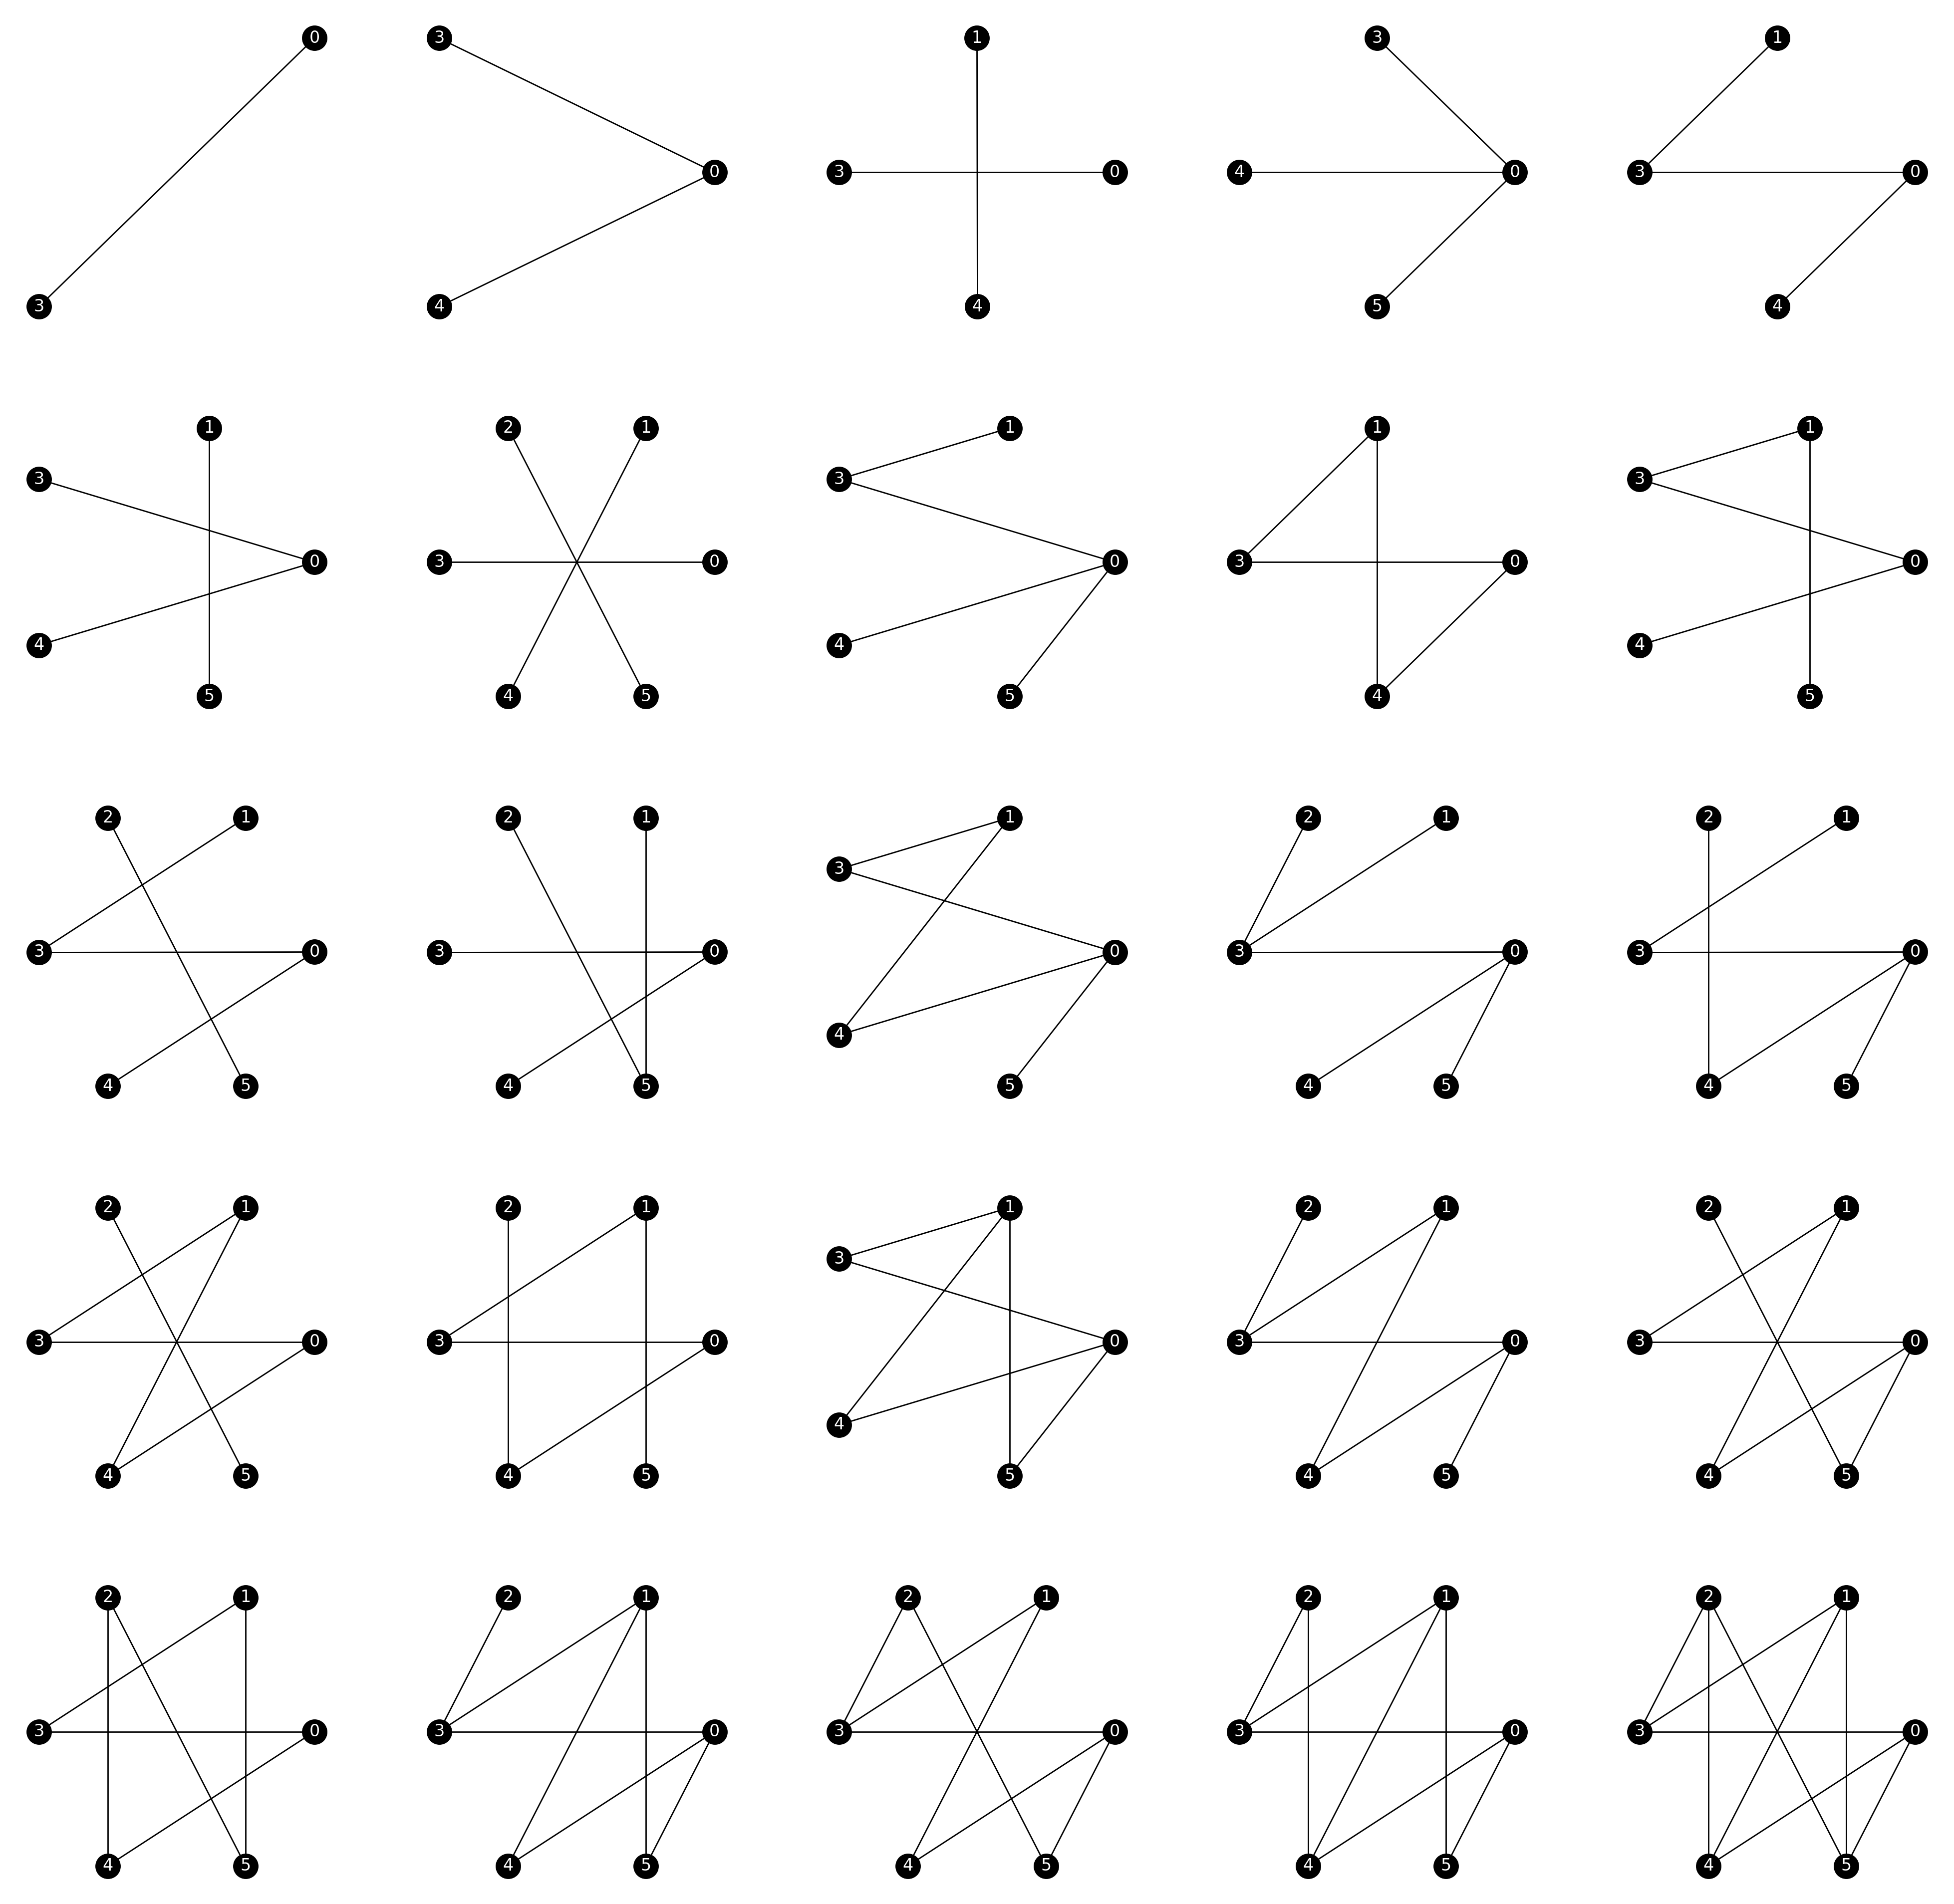

In [9]:
with open("K_3,3.UniqueGraphs.pickle","rb") as InputFile:
    UniqueSubgraphs = pickle.load(InputFile)
    
_draw_graph_list(UniqueSubgraphs)
plt.close()

In [10]:
# # Parse unique subgraphs into red/blue colorings and draw pictures with the red, blue, and host graph
# # Also determine the largest subgraph that is in both the red and blue subgrahs of each coloring and determine all of the possible ones, up to isomorphism
# # Determine total ordering and reduced poset graph for the ordering given by subset containment
for FileName in os.listdir(BaseDirectory):
    if ".UniqueGraphs.pickle" in FileName:
#         Get the n and m for the K_n,m host graph
        n,m=FileName.split(".",1)[0].split("K_",1)[1].split(",")
        n=int(n)
        m=int(m)
        HostGraph = nx.complete_multipartite_graph(n,m)
        
#         Pick up the list of unique subgraphs
        GraphName = f"K_{n},{m}"
        print(f"Inspecting {GraphName}")
        if not os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            continue
        UniqueSubgraphs = []
        CommonIntersectionSubgraphs = []
        with open(f"{GraphName}.UniqueGraphs.pickle", "rb") as InputFile:
            UniqueSubgraphs = pickle.load(InputFile)
            
#         Build a directory (if need be) and move into it for the given K_n,m
        if not os.path.exists(f"{GraphName}"):
            os.mkdir(f"{GraphName}")
        os.chdir(BaseDirectory+'/'+GraphName)
        
#         Work on the red-blue colorings
        counter = 1
        for RedSubgraph in UniqueSubgraphs:
#             Make BlueSubgraph
            BlueSubgraph = nx.edge_subgraph(HostGraph, set(HostGraph.edges())-set(RedSubgraph.edges())).copy()
            
#             Do the setup to hide 3 graphs in one picture (red, blue, biggest edge-induced subgraph of the red and blue subgraphs, and the host graph)
            fig,axes = plt.subplots(nrows=1,ncols=4)
            ax = axes.flatten()
            
#             Draw the red part
            nx.draw_kamada_kawai(RedSubgraph, with_labels=True, ax=ax[0], edge_color='red', node_color='black', font_color='white')
    
#             Draw the blue part
            nx.draw_kamada_kawai(BlueSubgraph, with_labels=True, ax=ax[1], edge_color='blue', node_color='black', font_color='white')
            
#             find the smaller of the two subgraphs (the red and the blue part)
            if RedSubgraph.size() > BlueSubgraph.size():
                SmallestSubgraph = RedSubgraph.copy()
                LargestSubgraph = BlueSubgraph.copy()
            else:
                SmallestSubgraph = BlueSubgraph.copy()
                LargestSubgraph = RedSubgraph.copy()
            
#             Determine the largest subgraph of both the red and the blue subgraphs
            for SubgraphSize in range(SmallestSubgraph.size(), 0, -1):
                LargestCommonSubgraph = None
                if SubgraphSize == 0:
                    LargestCommonSubgraph = nx.null_graph()
                    break
                for Edges in it.combinations(SmallestSubgraph.edges(), SubgraphSize):
                    SubSubgraph = nx.edge_subgraph(SmallestSubgraph, Edges).copy()
                    if nx.algorithms.isomorphism.GraphMatcher(nx.line_graph(LargestSubgraph), nx.line_graph(SubSubgraph)).subgraph_is_isomorphic():
                        LargestCommonSubgraph = SubSubgraph.copy()
                        CommonIntersectionSubgraphs.append(LargestCommonSubgraph.copy())
                        break
                if LargestCommonSubgraph is not None:
                    break
                    
#             Draw the largest common subgraph of the red and the blue subgraphs
            if LargestCommonSubgraph is not None:
                nx.draw_circular(LargestCommonSubgraph, with_labels=True, ax=ax[2], edge_color='green', node_color='green', font_color='white')
            else:
                nx.draw(nx.null_graph(), ax=ax[2])
    
#             Draw the host graph
            nx.draw_kamada_kawai(HostGraph, with_labels=True, ax=ax[3], edge_color='black', node_color='black', font_color='white')
    
#             Save the figure to file
            plt.savefig(f"{GraphName}.Red-Blue.Coloring.{counter}.png")
            plt.clf()
            plt.close()
            counter+=1
            
#         Determine the total ordering
        FixedSubgraphID = 1
        TotalOrderingAdjacencyList = ""
        AllGraphSizes = ""
        
#         Fix a particular unique subgraph and see which other unique subgraphs contain it
        for FixedSubgraph in UniqueSubgraphs:
            AllGraphSizes += f"Graph {FixedSubgraphID} has {FixedSubgraph.size()} edges\n"
            TotalOrderingAdjacencyList += f"{FixedSubgraphID}"
            HostGraphID = 1
            for HostGraph in UniqueSubgraphs:
                if nx.algorithms.isomorphism.GraphMatcher(nx.line_graph(HostGraph), nx.line_graph(FixedSubgraph)).subgraph_is_isomorphic():
                    TotalOrderingAdjacencyList += f" {HostGraphID}"
                HostGraphID += 1
            TotalOrderingAdjacencyList += "\n"
            FixedSubgraphID+=1
        with open(f"{GraphName}.Unique.Subgraphs.Information.txt", "w+") as OutFile:
            OutFile.write(AllGraphSizes)
        
#         Build a graph represening the total ordering of this K_n,m
        TotalOrderingGraph = nx.parse_adjlist(TotalOrderingAdjacencyList.splitlines(), create_using=nx.DiGraph())
        TotalOrderingGraph.remove_edges_from(nx.selfloop_edges(TotalOrderingGraph))
        
#         Draw the total ordering
        fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5),dpi=DPI)
        ax = axes
        nx.draw_circular(TotalOrderingGraph, with_labels=True, ax=ax, edge_color='teal', node_color='black', font_color='white')
        plt.savefig(f"{GraphName}.TotalOrdering.png")
        plt.clf()
        plt.close()
        
#         now restrict to just the relavent poset ordering
        GoodEdges = []
        for Edge in TotalOrderingGraph.edges():
#             print(Edge)
            if ((UniqueSubgraphs[int(Edge[1])-1].size())-(UniqueSubgraphs[int(Edge[0])-1].size()))==1:
#                 print(f"Case 1: Keeping the edge between graph {Edge[0]} (size {UniqueSubgraphs[int(Edge[0])-1].size()}) and graph {Edge[1]} (size {UniqueSubgraphs[int(Edge[1])-1].size()}).")
                GoodEdges.append((Edge[0],Edge[1]))
            elif ((UniqueSubgraphs[int(Edge[0])-1].size())-(UniqueSubgraphs[int(Edge[1])-1].size()))==1:
#                 print(f"Case 2: Keeping the edge between graph {Edge[0]} (size {UniqueSubgraphs[int(Edge[0])-1].size()}) and graph {Edge[1]} (size {UniqueSubgraphs[int(Edge[1])-1].size()}).")
                GoodEdges.append((Edge[0],Edge[1]))
#             else:
#                 print(f"Case 3: Rejecting the edge between graph {Edge[0]} (size {UniqueSubgraphs[int(Edge[0])-1].size()}) and graph {Edge[1]} (size {UniqueSubgraphs[int(Edge[1])-1].size()}).")
        ReducedPosetGraph = TotalOrderingGraph.edge_subgraph(GoodEdges).copy()
        
#         Draw the poset heirarchy
        fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(11,11),dpi=DPI)
        ax = axes
#         pos = hierarchy_pos(ReducedPosetGraph)
        positions = nx.spring_layout(ReducedPosetGraph, k=1)
        for Node in positions:
            positions[Node][1] = UniqueSubgraphs[int(Node)-1].size()
        nx.draw(ReducedPosetGraph, pos=positions, ax=axes, node_color="purple", edge_color="purple", font_color="white", with_labels=True)
        plt.savefig(f"{GraphName}.Poset.png")
        plt.clf()
        plt.close()
        with open(f"{GraphName}.ReducedPosetGraph.pickle", "wb") as OutFile:
            pickle.dump(ReducedPosetGraph, OutFile)
        
#         Determine the unique list of largest subgraphs of both the red and blue subgraphs in a particular coloring
        UniqueIntersectionSubgraphs = []
        for Graph in CommonIntersectionSubgraphs:
            Unique = True
            for UniqueGraph in UniqueIntersectionSubgraphs:
                if nx.is_isomorphic(Graph, UniqueGraph):
                    Unique = False
                    break
            if Unique:
                UniqueIntersectionSubgraphs.append(Graph)
        
#         Save the list of unique subgraphs that are the largest subgraph in both red and blue subgraphs of each coloring
        with open(f"{GraphName}.UniqueIntersectionSubgraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueIntersectionSubgraphs, OutFile)
        
#         Done with this K_n,m, return to the directory above
        os.chdir(BaseDirectory)

Inspecting K_2,3
Inspecting K_2,2
Inspecting K_1,1
Inspecting K_1,2
Inspecting K_1,3
Inspecting K_3,3


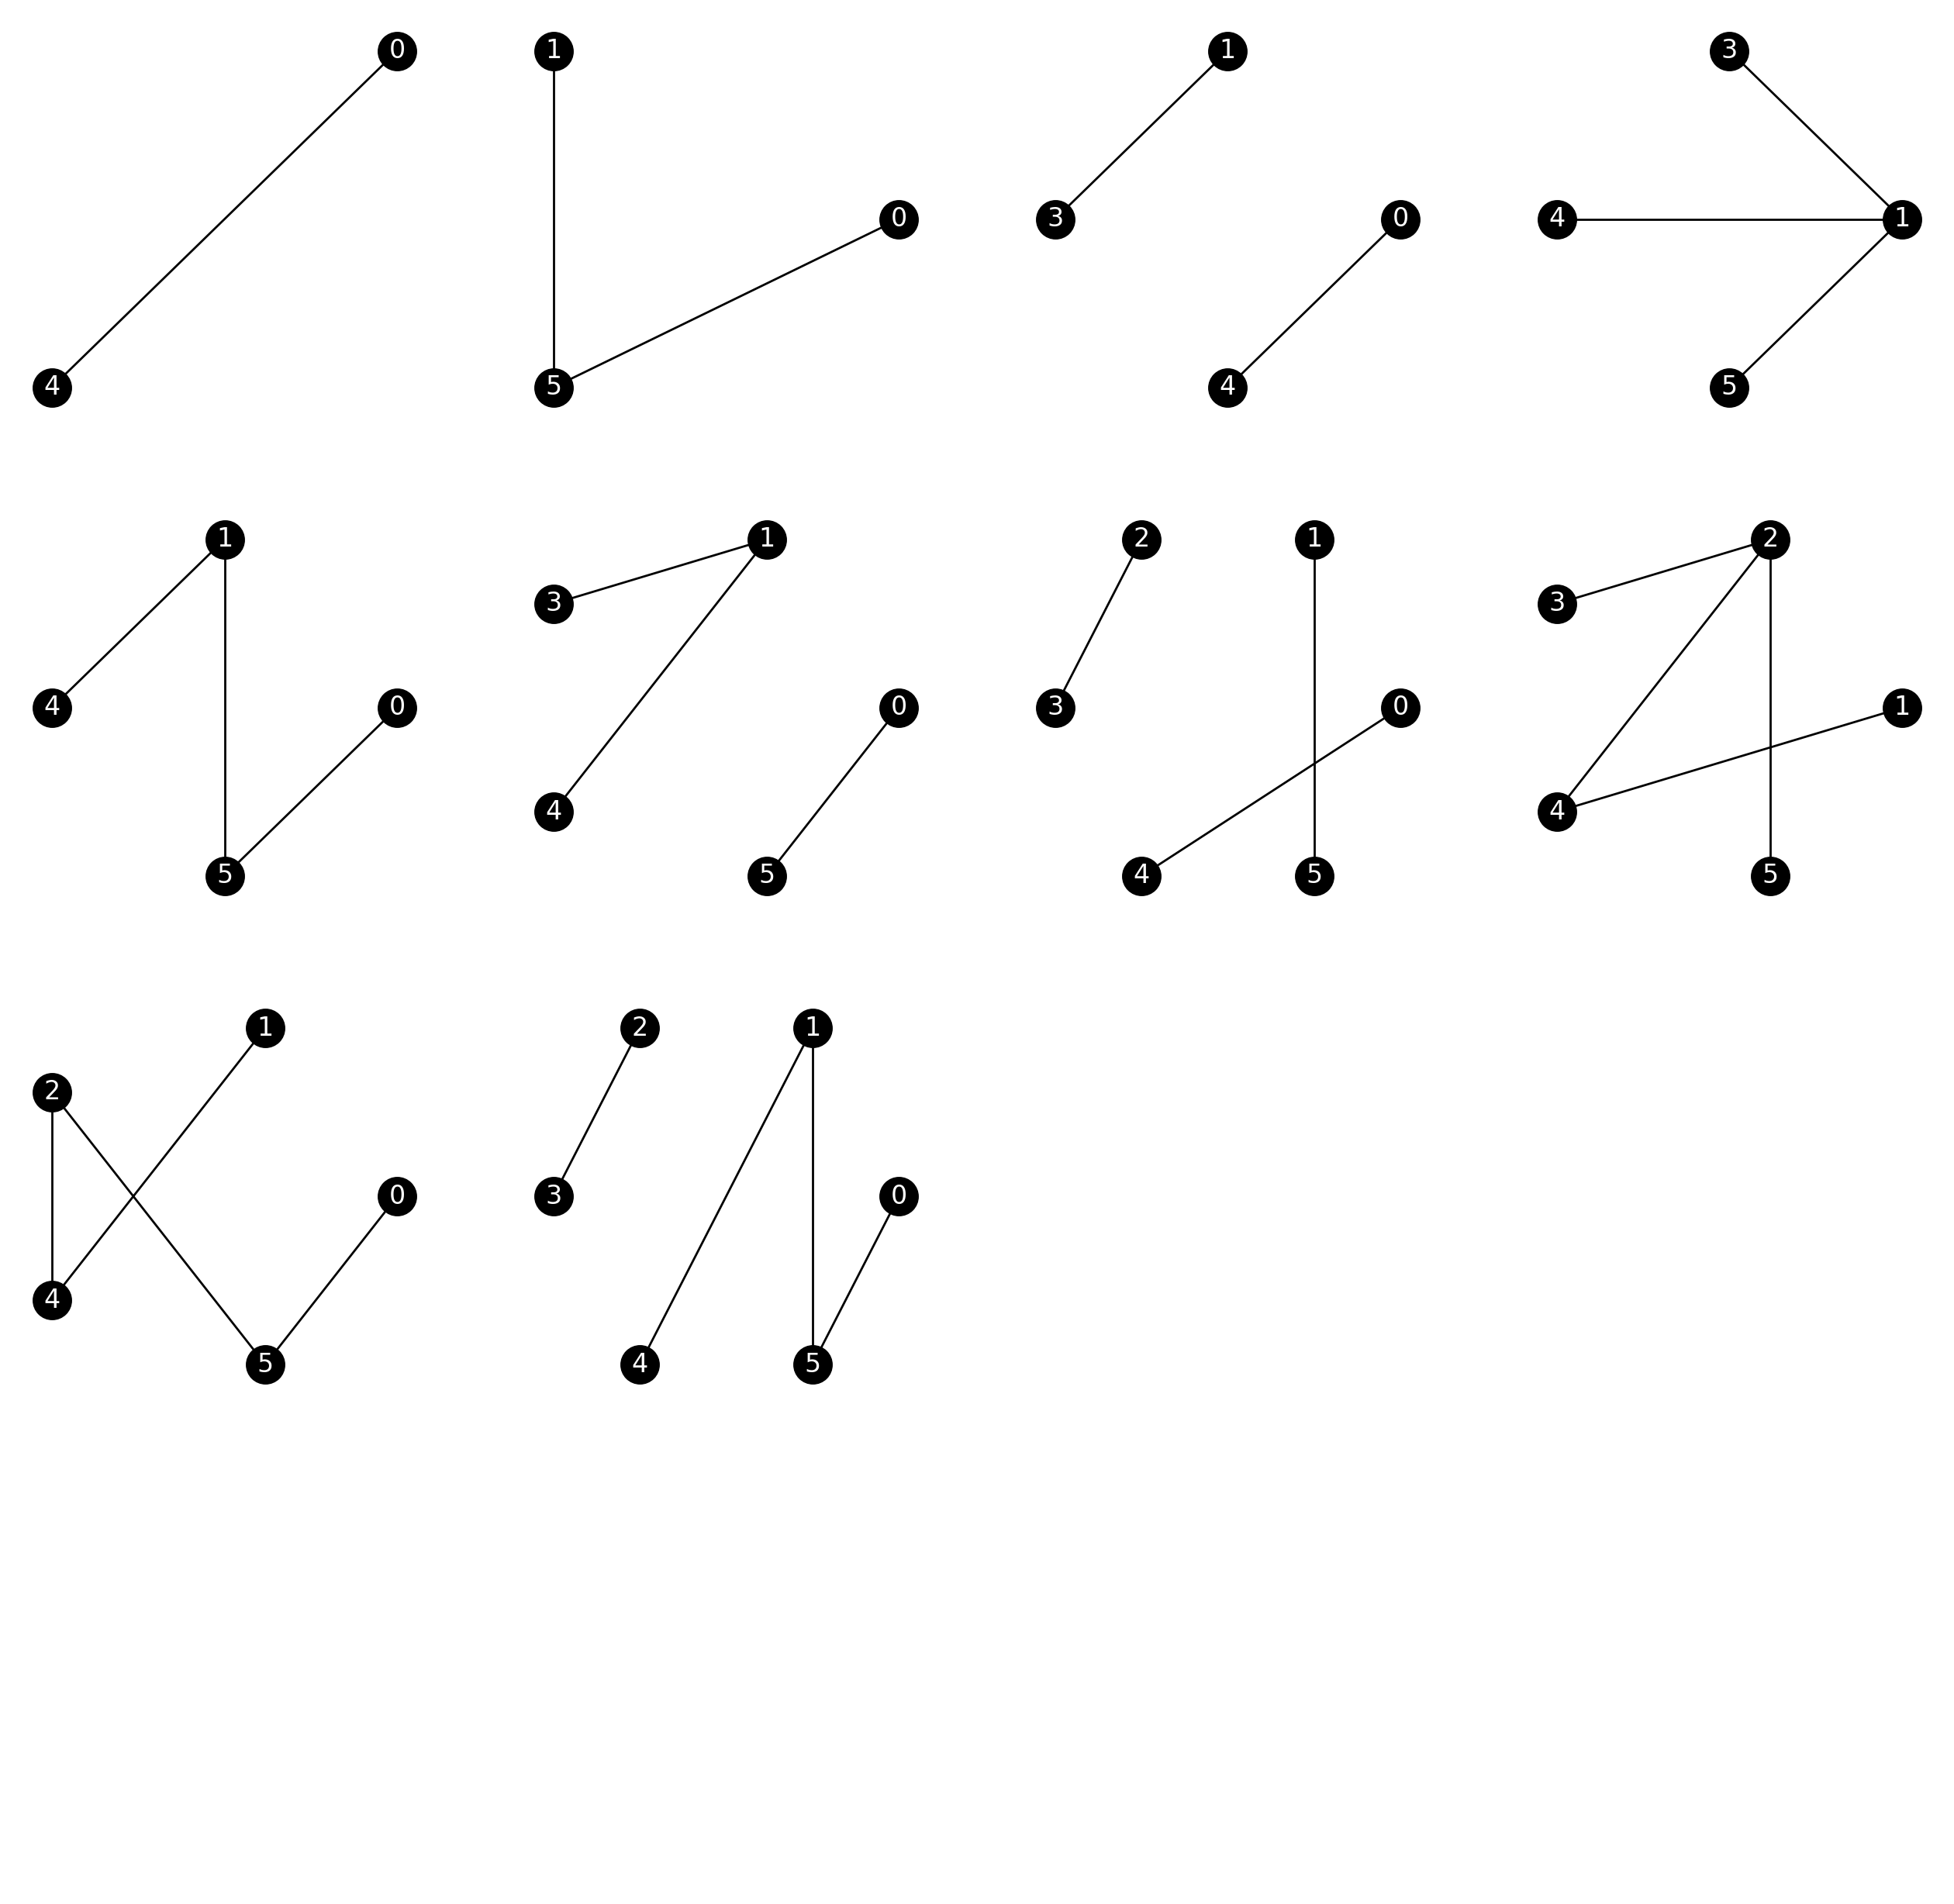

In [11]:
if os.path.exists("K_3,3"):
    os.chdir("K_3,3")
    with open("K_3,3.UniqueIntersectionSubgraphs.pickle","rb") as InputFile:
        UniqueSubgraphs = pickle.load(InputFile)

    _draw_graph_list(UniqueSubgraphs)
    plt.close()
    os.chdir(BaseDirectory)

In [12]:
# Display all of the, up to isomorphism, largest graphs that are a subgraph of both red and blue subgraphs induced by a particular coloring of K_n,m
for FileName in os.listdir(os.getcwd()):
    if ".UniqueGraphs.pickle" in FileName:
#         Get the n and m for the K_n,m host graph
        n,m=FileName.split(".",1)[0].split("K_",1)[1].split(",")
        n=int(n)
        m=int(m)
        HostGraph = nx.complete_multipartite_graph(n,m)
        GraphName = f"K_{n},{m}"
        print(f"Inspecting {GraphName}")
        
#         Move into the correct directory
        if os.path.exists(f"{GraphName}"):
            os.chdir(f"{GraphName}")
        else:
            print("Skipping, since the graph folder has not been made yet")
            continue
        
#         Pick up the list of unique subgraphs that are the in the red and blue subgraphs of each coloring
        if not os.path.exists(f"{GraphName}.UniqueIntersectionSubgraphs.pickle"):
            print("Skipping, since the unique intersection subgraphs list has not been made yet")
            continue
        UniqueSubgraphs = []
        CommonIntersectionSubgraphs = []
        with open(f"{GraphName}.UniqueIntersectionSubgraphs.pickle", "rb") as InputFile:
            UniqueIntersectionSubgraphs = pickle.load(InputFile)
        
        _save_graph_list(UniqueIntersectionSubgraphs, f"{GraphName}.Unique.Intersections.png")
        os.chdir(BaseDirectory)

Inspecting K_2,3
Inspecting K_2,2
Inspecting K_1,1
Inspecting K_1,2
Inspecting K_1,3
Inspecting K_3,3


In [13]:
print("Done")

Done
